In [1]:
# -*- coding:utf-8 -*-
import poloniex
import time
import json

# poloniex API
polo = poloniex.Poloniex()
# 2017/12/31 AM 12:00 @JP
#unix_time = 1514646000
unix_time = 1514732400

#4h間隔で過去180日分 UNIX時間で取得  #14400
chart_data_btc = polo.returnChartData('USDT_BTC', period=polo.DAY, start=unix_time-polo.DAY*365, end=unix_time)
chart_data_eth = polo.returnChartData('USDT_ETH', period=1800, start=unix_time-polo.DAY*180, end=unix_time)


In [2]:
import pandas as pd

# DataFrameに変換
df_btc = pd.DataFrame(chart_data_btc)
df_btc.tail(10)

,close,date,high,low,open,quoteVolume,volume,weightedAverage
355,13247.06419074,1513900800,15519.79447536,11362.39,15180.00000001,29968.89251945,396038503.84234,13214.98629237
356,13830,1513987200,14940,13000,13200.00000001,11453.33700481,162555092.92983,14192.81497275
357,13517.00000009,1514073600,13999,11703.13716406,13830,13389.67434668,172488515.64539,12882.20394158
358,13637.99999972,1514160000,14300,12702.8464126,13510.98484645,6181.97594595,83950439.713653,13579.87162157
359,15700.085745,1514246400,16050.65549987,13510.53958989,13637.99999972,8234.25934863,125250306.98157,15210.87710243
360,15370.01000001,1514332800,16500.90800028,14454,15690.00000006,8029.24523807,124139342.61595,15460.8981212
361,14307.3458536,1514419200,15464.07930619,13260.01051,15370.01000001,9301.91479356,130806984.96319,14062.37187355
362,14305.53422499,1514505600,15100,13770.00000005,14307.3458536,6966.730038,100213730.25999,14384.61512264
363,12351.93000029,1514592000,14365.38790685,11701.00000003,14305.53422499,12776.3452807,164673298.68738,12888.92050656
364,13769.34198361,1514678400,14145,12205,12390,7123.68044519,94241790.44347,13229.36804487


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
np.random.seed(1)

# 正規化
data_btc_ = pd.DataFrame([float(i.get('close')) for i in chart_data_btc])

mss = MinMaxScaler()
data_btc = pd.DataFrame(mss.fit_transform(data_btc_))

In [4]:
data_btc = np.array(data_btc.astype(np.float32))
data_btc_log = np.log(data_btc_)
data_btc_log = np.array(data_btc_log)

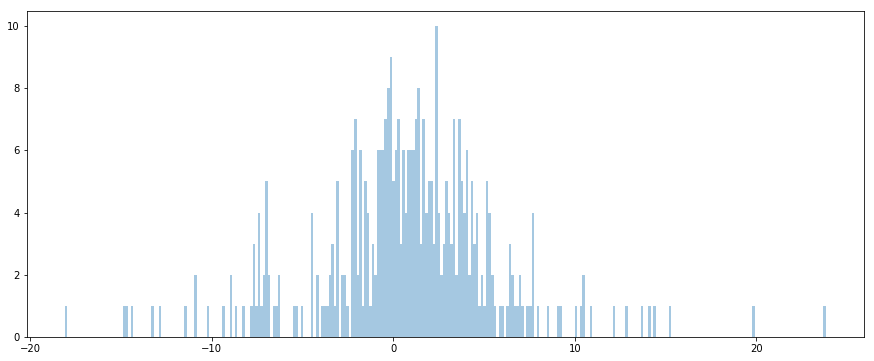

In [5]:
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6
import matplotlib.pyplot as plt

#前日との差
diff_btc = data_btc_log[1:] - data_btc_log[:-1]
diff_btc *= 100
sns.distplot(diff_btc, bins=300, kde=False)
plt.show()

In [6]:
# 標準偏差
diff_std = np.std(diff_btc)
diff_avg = np.average(diff_btc)
print(diff_avg)

print("前日比")
print("標準偏差[%]:{:.2f}".format(np.exp(diff_std/100)*100))
print("標準偏差[%]:{:.2f}".format(diff_std))
print("平均[%]:{:.2f}".format(diff_avg))

0.7206263976580686
前日比
標準偏差[%]:105.11
標準偏差[%]:4.98
平均[%]:0.72


In [7]:
import os
import collections
import re

# directory以下の全ファイル取得
def get_all_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # generator
            yield os.path.join(root, file)
            
# 読み込み            
def read_docment(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    return lines 

def trim_doc(lines,name):
    sep_docs = collections.OrderedDict()
    sep_doc = []

    # 文章ごとに区切る
    for s in range(len(lines)):
        # 空白行だったら
        if lines[s] == '\n':
            sep_docs[tag] = ''.join(sep_doc)
            sep_doc = []

        # 日時情報取得
        elif lines[s][-5:-2] == "201":
            day = lines[s][4:19]
            tag = day + " @ " + name
            continue

        # ツイート文章
        else :
            # URLを除去
            lines[s] = re.sub('https?://[\w/:%#\$&\?\(\)~\.=\+\-]+','',lines[s])

        sep_doc.append(lines[s])
    
    return sep_docs


for i in get_all_files('./database_test'):
    name = i.split('/')[2][:-4]
    raw_docs = read_docment(i) # list
    doc = trim_doc(raw_docs,name)
    
    for key, val in doc.items():
        print(key,val)

Dec 31 03:13:12 @ cissan_9984 ビットコイン下げそうだけど
どーだろ
含み益の人は税金の関係で今日は売りづらいだろうな、、、

Dec 29 04:54:26 @ cissan_9984 
ビットコインは年始の納税換金売りとビットフライヤーFX規制を警戒していったん売り
１８０万買い→１７６万売りのナイストレード！

Dec 28 06:28:51 @ cissan_9984 
ビットフライヤーのFX規制のお知らせ来てる！
流動性と使いやすさ、BTCのボラを考えると現物に対して乖離5%から5%超分の乖離金額の10%徴収とかがいいのでは？
10%乖離してると別物に見えるし、3%ぐらいだとヘッジなどに使いに… 

Dec 26 15:53:15 @ cissan_9984 
USD圏との鞘も小さくなってきたし
再始動の可能性高くなってきたのでビットコイン再度買ってみた

Dec 20 23:02:35 @ cissan_9984 
ビットコインFX市場の現物との乖離を抑えたいみたいだけど
現物との乖離が上に５%以上あったら開いてる時は買い方からスワップ取って売り方に渡す
下に５%以上あったら売り方からスワップ取って買い方に渡す
これがいいんじゃないかな！
H… 

Dec 18 02:44:06 @ cissan_9984 
現渡手数料２０％とか実質禁止手数料にしないで
現渡手数料無料で現渡までの期間１日
売り方金利は２日分取られるようにして
ライトニング上でできるようにする
これでFXの鞘も小さくなって、ビットフライヤーさんも儲かって
みんないいね！

Dec 18 02:35:27 @ cissan_9984 
ビットフライヤーのFXと現物の鞘が開くのを防ぐには
現渡しできるようにすればいいのでは？
それで一瞬ですべて解決
どちらにせよ。BTCが原資産なら今の鞘の乖離は異常事態だと思う
分岐コインの権利が無い分FXでの買いの方が劣化してるのに・・・

Dec 17 05:05:55 @ cissan_9984 
ビットフライヤーはFXに過熱規制を定めるのはまだいいとして
健全な取引所として公平にやって欲しいな
どちらかに懲罰スワップ0.2ぐらいかけるならそれは逆のポジションの人が受け取るべき
普通は過熱時は売り方が支払って買い方が受け取る

In [9]:
# onehotラベル生成　
_t_btc = np.empty((len(data_btc),4),dtype=np.float64)
# とりあえず閾値は1sigma
thresh = diff_std

# 棒グラフ用配列
bar_diff_btc = np.zeros(4)

for i in range(1,len(data_btc)):
    # めっちゃ上がる
    if diff_btc[i-1] >= thresh:  
        _t_btc[i] = np.array([1,0,0,0])
        bar_diff_btc[0] = bar_diff_btc[0] + 1
    # 上がる
    elif diff_btc[i-1] >= 0 and diff_btc[i-1] < thresh: 
        _t_btc[i] = np.array([0,1,0,0])
        bar_diff_btc[1] = bar_diff_btc[1] + 1
    # 下がる
    elif diff_btc[i-1] >= -thresh and  diff_btc[i-1] < 0: 
        _t_btc[i] = np.array([0,0,1,0])
        bar_diff_btc[2] = bar_diff_btc[2] + 1
    # めっちゃ下がる
    else : 
        _t_btc[i] = np.array([0,0,0,1])
        bar_diff_btc[3] = bar_diff_btc[3] + 1

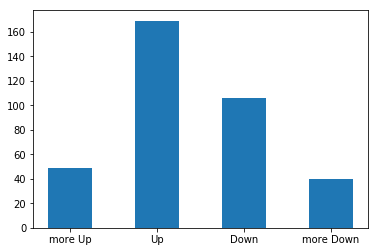

array([ 49., 169., 106.,  40.])

In [10]:
rcParams['figure.figsize'] = 6, 4
left = np.array([1, 2, 3, 4])
label = ["more Up","Up","Down","more Down"]
plt.bar(left, bar_diff_btc, tick_label=label, align="center",width=0.5)
plt.show()

bar_diff_btc

In [11]:
# データを入力変数xと出力変数tに切り分け
x_btc, t_btc= [], []

N = len(data_btc)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
 # 入力変数と出力変数の切り分け
 _x = data_btc[n-M: n] # 入力変数
 _t = _t_btc[n] # 出力変数
 # 計算用のリスト(x, t)に追加していく
 x_btc.append(_x)
 t_btc.append(_t)


In [25]:
x_btc.shape

(335, 30, 1)

In [12]:
# numpyに変換
# x.shape : 1050,30 t.shape : 1050,1
x_btc = np.array(x_btc)
t_btc = np.array(t_btc)

x_btc = x_btc.reshape(x_btc.shape[0], x_btc.shape[1], 1)
N_train = int(len(x_btc) * 0.9)
x_train, x_test = x_btc[:N_train], x_btc[N_train:]
t_train, t_test = t_btc[:N_train], t_btc[N_train:]

In [27]:
x_btc.shape

(335, 30, 1)

In [23]:
# model
# 4分類
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
print(t_btc.shape)
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30
model = Sequential()
# return_sequenceとは、TrueにしてRNNレイヤーの毎時刻の出力を得るか、Falseにして最後の時刻のみの出力を得るか、のフラグ
# batch_iuput_shape: ([バッチサイズ，step数，特徴の次元数])
model.add(LSTM(units=n_hidden,
               batch_input_shape=(None, length_of_sequence, n_in), 
               return_sequences=False
              ))
model.add(Dropout(0.5))
model.add(Dense(n_out))
model.add(Activation("softmax"))
optimizer = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) # metrics = ['categorical_accuracy']

model.summary()

(335, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 124       
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________


In [62]:
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Input, Dense, Dropout, concatenate, LSTM, Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30

# LSTMモデル　作成(入力：価格)
# batch_iuput_shape: ([バッチサイズ，step数，特徴の次元数])
price_input = Input(shape=(length_of_sequence,n_in), name="price_input")
price_output = LSTM(units=n_hidden,batch_input_shape=(None, length_of_sequence, n_in), return_sequences=False)(price_input)
price_output = Dropout(0.5)(price_output)
price_output = Dense(n_out, activation="softmax")(price_output)
model = Model(input=price_input, output= price_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # metrics = ['categorical_accuracy']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
price_input (InputLayer)     (None, 30, 1)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 124       
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________


/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("pr...)`


# ベクトル化したツイートを読み込み

In [35]:
tweet_vec = np.load("tweet_vec.npy")
tweet_vec = tweet_vec[29:-1]

N_train = int(len(tweet_vec) * 0.9)
tweet_train, tweet_test = tweet_vec[:N_train], tweet_vec[N_train:]

In [36]:
tweet_train.shape

(301, 400)

# 2入力1出力モデル

In [68]:
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Input, Dense, Dropout, concatenate, LSTM, Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30

# LSTMモデル　作成(入力：価格)
price_input = Input(shape=(length_of_sequence, n_in), name="price_input")
price_output = LSTM(units=n_hidden,batch_input_shape=(None, length_of_sequence, n_in), return_sequences=False)(price_input)
price_output = Dropout(0.5)(price_output)
#price_output = Dense(n_out, activation="sigmoid")(price_output)

# 全結合モデル作成 (入力：ツイッター)
twitter_input = Input(shape=(400,), dtype="float32", name="twitter_input")
#twitter_output = Dense(256, activation="relu")(twitter_input)
#twitter_output = Dropout(0.5)(twitter_output)
#twitter_output = Dense(10,activation="softmax")(twitter_output)

# もう少し早く連結
x = concatenate([price_output, twitter_input])
main_output = Dense(n_out, activation='softmax', name='main_output')(x)
# 2つのモデルの出力を結合
#main_output = concatenate([price_output, twitter_output])

# 結合後の層
#main_output = Dense(512, activation="relu")(model_output)
#main_output = Dense(10, activation="softmax")(model_output)

#model = Model(input=[price_input, twitter_input], output= [main_output, price_output, twitter_output])
model = Model(inputs=[price_input, twitter_input], outputs= [main_output])

#model.compile(loss="categorical_crossentropy", optimizer="adam", loss_weights=[1.0, 0.5, 0.3], metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer="adam" ,metrics=["accuracy"])
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
price_input (InputLayer)         (None, 30, 1)         0                                            
____________________________________________________________________________________________________
lstm_11 (LSTM)                   (None, 30)            3840        price_input[0][0]                
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 30)            0           lstm_11[0][0]                    
____________________________________________________________________________________________________
twitter_input (InputLayer)       (None, 400)           0                                            
___________________________________________________________________________________________

# 過去価格のみで予測

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(x_train, t_train,
          batch_size=20,
          epochs=20,
          #validation_split=0.1,
          shuffle=True,
          callbacks=[early_stopping]
          )

Epoch 1/20
301/301 [==============================] - 2s - loss: 1.3739 - acc: 0.4120     
Epoch 2/20
 40/301 [==>...........................] - ETA: 0s - loss: 1.3441 - acc: 0.5250

/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


301/301 [==============================] - 1s - loss: 1.3261 - acc: 0.4651     
Epoch 3/20
301/301 [==============================] - 1s - loss: 1.2698 - acc: 0.4784     
Epoch 4/20
301/301 [==============================] - 1s - loss: 1.2428 - acc: 0.4485     
Epoch 5/20
301/301 [==============================] - 1s - loss: 1.2423 - acc: 0.4319     
Epoch 6/20
301/301 [==============================] - 1s - loss: 1.2372 - acc: 0.4352     
Epoch 7/20
301/301 [==============================] - 1s - loss: 1.2536 - acc: 0.4618     
Epoch 8/20
301/301 [==============================] - 1s - loss: 1.2221 - acc: 0.4917     
Epoch 9/20
301/301 [==============================] - 1s - loss: 1.2387 - acc: 0.4618     
Epoch 10/20
301/301 [==============================] - 1s - loss: 1.2308 - acc: 0.4850     
Epoch 11/20
301/301 [==============================] - 1s - loss: 1.2278 - acc: 0.4684     
Epoch 12/20
301/301 [==============================] - 1s - loss: 1.2342 - acc: 0.4751     
Epoch 1

# 過去価格＋ツイートで予測

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

model.fit([x_train,tweet_train], t_train,
          batch_size=20,
          epochs=20,
          shuffle=True,
          callbacks=[early_stopping]
          )

Epoch 1/20
301/301 [==============================] - 2s - loss: 1.3790 - acc: 0.4153     
Epoch 2/20
 40/301 [==>...........................] - ETA: 1s - loss: 1.3734 - acc: 0.3750

/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


301/301 [==============================] - 1s - loss: 1.3590 - acc: 0.4684     
Epoch 3/20
301/301 [==============================] - 1s - loss: 1.2704 - acc: 0.4751     
Epoch 4/20
301/301 [==============================] - 1s - loss: 1.2366 - acc: 0.4718     
Epoch 5/20
301/301 [==============================] - 1s - loss: 1.2224 - acc: 0.4751     
Epoch 6/20
301/301 [==============================] - 1s - loss: 1.2119 - acc: 0.4784     
Epoch 7/20
301/301 [==============================] - 1s - loss: 1.2308 - acc: 0.4651     
Epoch 8/20
301/301 [==============================] - 1s - loss: 1.2267 - acc: 0.4784     
Epoch 9/20
301/301 [==============================] - 1s - loss: 1.2258 - acc: 0.4684     
Epoch 10/20
301/301 [==============================] - 1s - loss: 1.2262 - acc: 0.4485     
Epoch 11/20
301/301 [==============================] - 1s - loss: 1.2421 - acc: 0.4684     
Epoch 12/20
301/301 [==============================] - 1s - loss: 1.2189 - acc: 0.4551     
Epoch 1

In [72]:
# 正答率、準正答率（騰落）集計
preds = model.predict([x_test,tweet_test])
correct = 0
semi_correct = 0
for i in range(len(preds)):
  pred = np.argmax(preds[i,:])
  tar = np.argmax(t_test[i,:])
  if pred == tar :
    # 純粋な正解率
    correct += 1
  else :
    # 上下は当たってるやつ
    if pred+tar == 1 or pred+tar == 5 : 
      semi_correct += 1

print("正答率:", 1.0 * correct / len(preds))
print("準正答率（騰落）:", 1.0 * (correct+semi_correct) / len(preds))


正答率: 0.29411764705882354
準正答率（騰落）: 0.5294117647058824


In [73]:
preds[1,:]

array([0.14336817, 0.45491624, 0.28399947, 0.11771618], dtype=float32)